# **Project8 - Plant Seedlings Classification**

## **Context**

* In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

* The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## **Objective**

* Need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

## **Data**

The data file names are:

**images.npy**

**Label.csv**

>**List of Plant species**

* Black-grass

* Charlock

* Cleavers

* Common Chickweed

* Common Wheat

* Fat Hen

* Loose Silky-bent

* Maize

* Scentless Mayweed

* Shepherds Purse

* Small-flowered Cranesbill

* Sugar beet

## **Importing the necessary libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns
import random

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import backend

from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the dataset**

In [2]:
# Mount Google drive to access the dataset (monkeys_dataset.zip)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/GL-AIML/Introduction_to_Computer_Vision/Project/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/GL-AIML/Introduction_to_Computer_Vision/Project/Labels.csv')

## **Overview of the dataset**

###**Data shape**

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.

###**Plotting images using OpenCV and matplotlib**

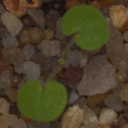

In [5]:
cv2_imshow(images[5])

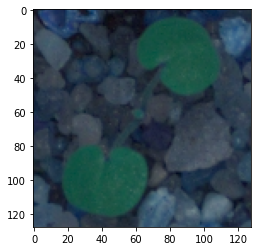

In [6]:
plt.imshow(images[5])

In [7]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV so we could interpret them easily.
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis** 

In [8]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

In [9]:
def find_index(data, target):
  res = []
  lis = data
  while True:
    try:
      res.append(lis.index(target) + (res[-1]+1 if len(res)!=0 else 0))
      lis = data[res[-1]+1:]
    except:
      break     
  return res

###**Sample images from each category**

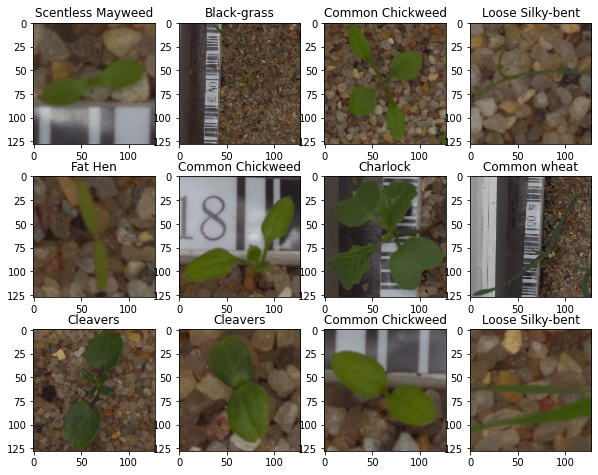

In [10]:
plot_images(images,labels)

In [11]:
categories = labels['Label'].unique()
label_list =list(labels['Label'])
for idx,label in enumerate(categories):
  subset_idx = labels[labels['Label']==label].index

Small-flowered Cranesbill


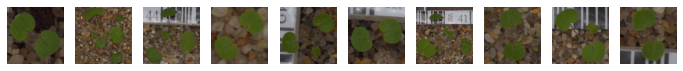

Fat Hen


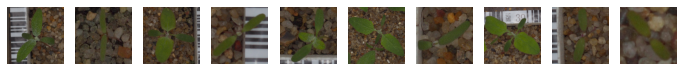

Shepherds Purse


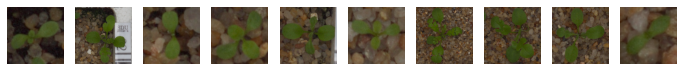

Common wheat


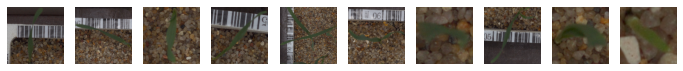

Common Chickweed


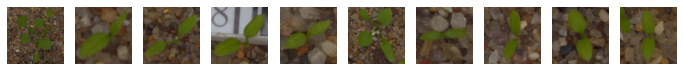

Charlock


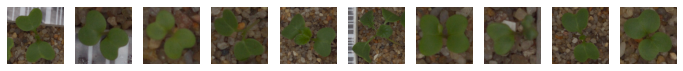

Cleavers


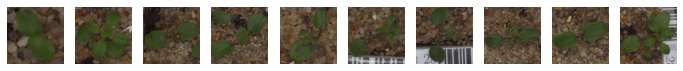

Scentless Mayweed


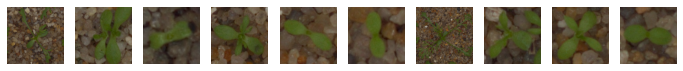

Sugar beet


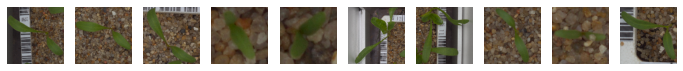

Maize


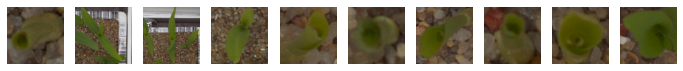

Black-grass


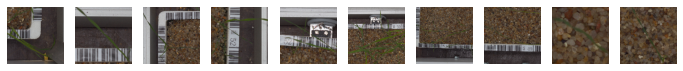

Loose Silky-bent


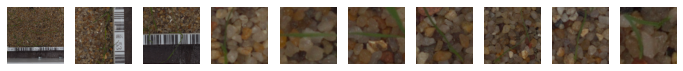

In [12]:
random.seed(5)
for i,label in enumerate(categories):
  label_name = categories[i]
  print (label_name)
  image_set_idx = random.sample(find_index(label_list,label),10)
  plt.figure(figsize=(12,20))
  for j,img_idx in enumerate(image_set_idx):
    sub_image = images[image_set_idx[j]]
    plt.subplot(10,10,j+1)
    plt.imshow(sub_image)
    plt.axis('off')
  plt.show()


* It was observed that the image contained elements that could interfere with classification, such as barcodes and soil, in addition to the seedlings to be classified.

###**Checking for data imbalance**

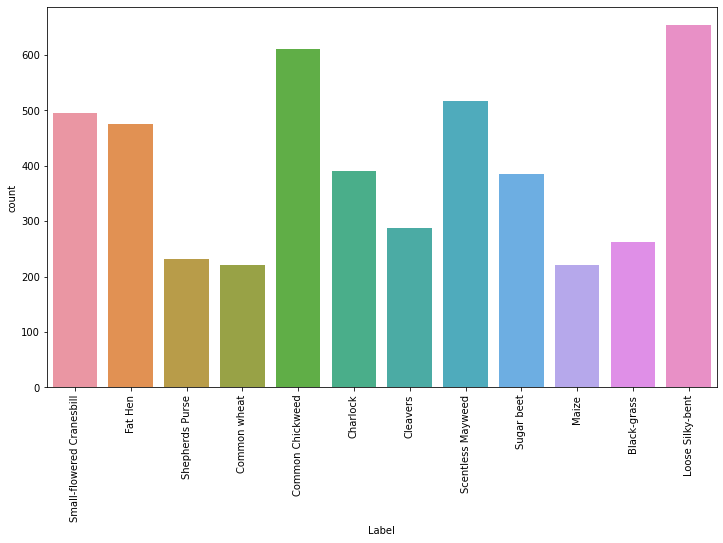

In [13]:
plt.figure(figsize=(12,7))
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')
plt.show()

In [14]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

* Among the data, loose silky-bent accounted for the largest number, and common wheat and maize had the smallest number.
* The dataset is imbalanced.

###**Key Observations from EDA**

* The dataset is imbalanced.
* If the image contains many obstacles such as barcodes that are not subject to classification, it will help to improve model performance if they can be removed.


##**Data pre-processing**

###**Visualizing images using Gaussian Blur**

In [15]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

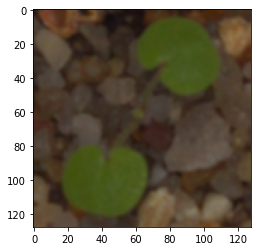

In [16]:
plt.imshow(images_gb[5])

* Even after Gaussian blur processing, it still contains a lot of information that is not related to the seedling.


###**Data Normalization**

Since the value range of image data is from 0 to 255, it is scaled to come from 0 to 1 by dividing by 255.


In [17]:
images_scaled = np.array(images_gb)/255.0

###**Resizing images**

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [18]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images_scaled)):
  images_decreased.append( cv2.resize(images_scaled[i], dimensions, interpolation=cv2.INTER_LINEAR))

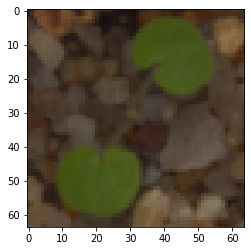

In [19]:
plt.imshow(images_decreased[5])

###**Comparison before and after pre-processing**


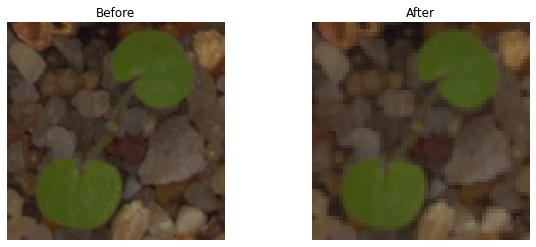

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(images[5])
plt.axis('off')
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(images_decreased[5])
plt.axis('off')
plt.title('After')
plt.show()

###**Splitting the dataset**

In [21]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_scaled),labels , test_size=0.1, random_state=5,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=5,stratify=y_temp)

###**Encoding the target labels**

In [22]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [23]:
print(y_train_encoded.shape)
y_train_encoded

(3847, 12)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
print(y_val_encoded.shape)
y_val_encoded

(428, 12)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
print(y_test_encoded.shape)
y_test_encoded

(475, 12)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]])

## **Model Builing - Convolutional Neural Network (CNN)**

### **Model-1**

####**Model builing**

In [26]:
# Clearing backend
backend.clear_session()

In [27]:
# Fixing the seed for random number generators
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

In [28]:
# Intializing a sequential model
model_1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model_1.add(Conv2D(64, (3, 3), padding="same", activation='relu',input_shape=(128, 128, 3)))
model_1.add(Conv2D(64, (3, 3), activation='relu',padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3),activation='relu', padding="same"))
model_1.add(Conv2D(32, (3, 3),activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model_1.add(Dense(12, activation='softmax'))

opt=Adam(learning_rate=1e-3)
# Compile model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [29]:
# Calculating class weight
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(categories),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(label_list))), class_weights))
class_weights

{0: 0.7994596841230258,
 1: 0.8326839826839827,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

In [30]:
history_1 = model_1.fit(
            X_train, y_train_encoded,
            epochs=30,
            validation_data=(X_val,y_val_encoded),
            batch_size=32,
            verbose=2,
            class_weight=class_weights
)

Epoch 1/30


KeyboardInterrupt: ignored

####**Model Evaluation**

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Both the training and validation accuracy of the model are good.
* The built model is overfitting on the training data.


#### **Evaluating the model on test data**

In [ ]:
accuracy = model_1.evaluate(X_test, y_test_encoded, verbose=2)

The accuracy of the test set is about 68%, similar to that of the validation set.

#### **Generating the predictions using test data**

In [ ]:
y_pred=model_1.predict(X_test)

In [ ]:
y_pred

#### **Plotting the Confusion Matrix**

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=categories,
    yticklabels=categories
)
plt.show()

* It was observed that some classes are not predicted correctly.
* Most of Small-flowered Cranebill and Common Chickweed tend to be misclassified as Cleavers.

#### **Classification Report on Test set**

In [ ]:

y_test_arg_str = [categories[test_idx] for test_idx in y_test_arg]
y_pred_arg_str = [categories[pred_idx] for pred_idx in y_pred_arg]

In [ ]:
print(classification_report(y_test_arg_str,y_pred_arg_str))

* When considered comprehensively, the classification performance of Black-grass is the best, and Small-flowered Cranesbill cannot be classified at all.


### **Model-2**


The initial model was slightly overfitted and had a problem of not distinguishing some classes well.

Performance improvement was attempted through data augmentation and batch normalization.

#### **Data Augmentation**

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

In [ ]:
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = True, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              )

In [ ]:
# Intializing a sequential model
model_2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model_2.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(128, 128, 3)))
model_2.add(Conv2D(64, (3, 3),activation='relu',padding="same"))

model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(BatchNormalization())

model_2.add(Conv2D(32, (3, 3),activation='relu', padding="same"))
model_2.add(Conv2D(32, (3, 3), activation='relu',padding="same"))

model_2.add(MaxPooling2D((2, 2), padding = 'same'))

model_2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(16, activation='relu'))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model_2.add(Dense(12, activation='softmax'))

opt=Adam(learning_rate=1e-4)
# Compile model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_2.summary()

In [ ]:
history_2 = model_2.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=32, 
                                       seed=5,
                                       shuffle=False),
                    epochs=30,
                    validation_data=(X_val,y_val_encoded),
                    class_weight=class_weights,
                    verbose=2)

####**Model Evaluation**

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Both the training and validation accuracy of the model are good..
* The built model is not overfitting on the training data.
* The accuracy of the validation set have been fluctuated during the training process.


#### **Evaluating the model on test data**

In [ ]:
accuracy = model_2.evaluate(X_test, y_test_encoded, verbose=2)

* It was observed that the accuracy has improved compared to previous model.

#### **Generating the predictions using test data**

In [ ]:
y_pred_2 = model_2.predict(X_test)

In [ ]:
y_pred_2

#### **Plotting the Confusion Matrix**

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_2_arg=np.argmax(y_pred_2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=categories,
    yticklabels=categories
)
plt.show()

* It was observed that some classes are not predicted correctly.
* Most of Small-flowered Cranebill, Common Chickweed and Scentless Mayweed tend to be misclassified as Cleavers.
* The problem of misclassification of certain groups has not been resolved.

#### **Classification Report on Test set**

In [ ]:
y_test_arg_str = [categories[test_idx] for test_idx in y_test_arg]
y_pred_2_arg_str = [categories[pred_2_idx] for pred_2_idx in y_pred_2_arg]

In [ ]:
print(classification_report(y_test_arg_str,y_pred_2_arg_str))

* When considered comprehensively, the classification performance of Black-grass is the best, and Scentless Mayweed cannot be classified at all.


###**Model-3**

There was still a problem of not being able to classify a specific class well, and transfer learning was performed using the VGG16.


####**Transfer Learning**

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model.summary()

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(5)
random.seed(5)
tf.random.set_seed(5)

In [ ]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())


# Adding a fully connected dense layer
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.1))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem  
model_3.add(Dense(12, activation='softmax'))

opt=Adam(learning_rate=1e-2)
# Compile model
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_3.summary()

In [ ]:
history_3 = model_3.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=32, 
                                       seed=5,
                                       shuffle=False),
                    epochs=30,
                    validation_data=(X_val,y_val_encoded),
                    class_weight=class_weights,
                    verbose=2)

####**Model Evaluation**

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Both the training and validation accuracy of the model are good..
* The built model is not overfitting on the training data.
* The accuracy of the validation set have been fluctuated during the training process.


#### **Evaluating the model on test data**

In [ ]:
accuracy = model_3.evaluate(X_test, y_test_encoded, verbose=2)

* It was observed that the accuracy has improved compared to previous model.

#### **Generating the predictions using test data**

In [ ]:
y_pred_3 = model_3.predict(X_test)

In [ ]:
y_pred_3

#### **Plotting the Confusion Matrix**

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_3_arg=np.argmax(y_pred_3,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_3_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=categories,
    yticklabels=categories
)
plt.show()

* It was observed that some classes are not predicted correctly.
* Most of Small-flowered Cranebill, Common Chickweed and Scentless Mayweed tend to be misclassified as Cleavers.
* The problem of misclassification of certain groups has not been resolved.

#### **Classification Report on Test set**

In [ ]:
y_test_arg_str = [categories[test_idx] for test_idx in y_test_arg]
y_pred_3_arg_str = [categories[pred_3_idx] for pred_3_idx in y_pred_3_arg]

In [ ]:
print(classification_report(y_test_arg_str,y_pred_3_arg_str))

* When considered comprehensively, the classification performance of Black-grass is the best, and Scentless Mayweed cannot be classified at all.


##**Conclusion**

* In Model-2, data augmentation was used to improve the performance of the existing model, and the test accuracy was 75%.

* Transfer learning using convolutional layers of VGG16 did not show satisfactory performance, and the difference between the input size originally used in VGG16 and the input size of the dataset is thought to be the cause.

* If the background of the seedling image can be removed in the training and prediction phases, the performance could be improved.